In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Set up Tensorboard Logging**

In [ ]:
%load_ext tensorboard


# Clear any tensorflow logs from previous runs
!rm -rf ./logs/ 

**Import Dataset**

Datset are in the form of Numpy arrays


In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import os
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)
from skimage import transform as tf

import random


path='/content/drive/My Drive/Balanced Dataset Covid/'
Dataset='NSTstarry_night_covid224'
batch_size=32


def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']
        

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

(x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)


Using TensorFlow backend.


**Data Normalization**

Total number of outputs :  2
Output classes :  [0 1]
(224, 224, 3)
868


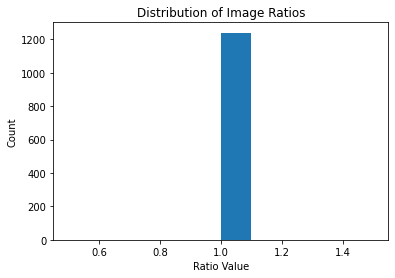

In [ ]:


y_train=y_train.reshape(y_train.shape[0],1)
y_testing=y_testing.reshape(y_testing.shape[0],1)

x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

x_train/=255
x_test/=255
training_size=len(x_train)
test_size=len(y_testing)
classes = np.unique(y_train)
nClasses = len(classes)
num_classes = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
img_rows=x_train[0].shape[0]
img_cols=x_train[1].shape[0]
input_shape=(img_rows,img_cols,3)
print(input_shape)
print(len(x_train))


y = dict()
y[0] = []
y[1] = []
for set_name in (y_train,y_testing):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(x=['Train Set', 'Test Set'],y=y[0],name='No',marker=dict(color='#33cc33'),opacity=0.7)
trace1 = go.Bar(x=['Train Set','Test Set'],y=y[1],name='Yes',marker=dict(color='#ff3300'),opacity=0.7)
data = [trace0, trace1]
layout = go.Layout(title='Count of classes in each set',xaxis={'title': 'Set'},yaxis={'title': 'Count'})
fig = go.Figure(data, layout)
iplot(fig)



RATIO_LIST = []
for set in (x_train, x_test):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

**Define Image generators**

In [ ]:
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True)
val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True)


# Define Callback function for early stopping and tensorboard
earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy'
                                        ,patience=5
                                        ,verbose=0
                                        ,factor=0.5
                                        ,min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%h$m%s"))
Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

**CNN Architecture**

In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# summarize the model
model.summary()

# from keras.regularizers import l2
# model=Sequential()
# model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.001), input_shape=x_train.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(2,2))


# model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))


# model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.001)))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))

# # model.add(Conv2D(160, (3, 3), kernel_regularizer=l2(0.00001)))
# # model.add(Activation('relu'))
# # model.add(Dropout(0.2)
# # model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.0001)))
# # model.add(Activation('relu'))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(2))
# model.add(Dropout(0.2))
# model.add(Activation("softmax"))
# print(model.summary())


optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# sparse_categorical_crossentropy

# Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

# print("Number of weights after calling the model:", len(model.weights)) 


553467904/553467096 [==============================] - 18s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

**Fit Model**

In [ ]:
epochs=50

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)


# fit model
train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)

history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator,
      verbose=1,
      shuffle=True
      ,
     callbacks=[earlystop, learning_rate_reduction,mc]
     )

# print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(
# history.history['val_loss'][-1], 
# history.history['val_accuracy'][-1]))

# saved_model = load_model('best_model.h5')
# evaluate the model
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
_, test_acc = model.evaluate(x_test, y_testing, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning:

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning:

This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.



14/14 [==============================] - 8s 603ms/step - loss: 0.6982 - accuracy: 0.5336 - val_loss: 0.6892 - val_accuracy: 0.4649
Epoch 2/50
14/14 [==============================] - 8s 607ms/step - loss: 0.6167 - accuracy: 0.6636 - val_loss: 0.4753 - val_accuracy: 0.7784
Epoch 3/50
14/14 [==============================] - 8s 596ms/step - loss: 0.4687 - accuracy: 0.8028 - val_loss: 0.5456 - val_accuracy: 0.7838
Epoch 4/50
14/14 [==============================] - 9s 611ms/step - loss: 0.3889 - accuracy: 0.8260 - val_loss: 0.5951 - val_accuracy: 0.7892
Epoch 5/50
14/14 [==============================] - 8s 600ms/step - loss: 0.3425 - accuracy: 0.8631 - val_loss: 0.3375 - val_accuracy: 0.7892
Epoch 6/50
14/14 [==============================] - 9s 613ms/step - loss: 0.3576 - accuracy: 0.8469 - val_loss: 0.2923 - val_accuracy: 0.8162
Epoch 7/50
14/14 [==============================] - 8s 600ms/step - loss: 0.2794 - accuracy: 0.8770 - val_loss: 0.6771 - val_accuracy: 0.8162
Epoch 8/50
14/14 

**Plot the training and validation accuracy**

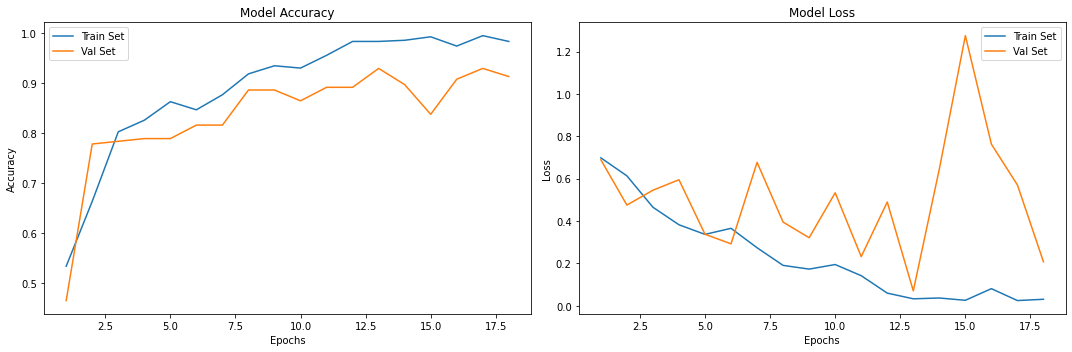

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


# predictions =model.predict_classes(x_test, verbose=1)
# validate on val set

# predictions = [1 if x>0.5 else 0 for x in predictions]
# print(predictions)
# accuracy = accuracy_score(y_testing, predictions)
# print('Val Accuracy = %.2f' % accuracy)

# confusion_mtx = confusion_matrix(y_testing, predictions) 
# cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

**Calculate roc curve and area under curve**

In [ ]:
fpr , tpr , thresholds = roc_curve ( y_testing , y_val_cat_prob)
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    
plot_roc_curve (fpr,tpr)


auc_score=roc_auc_score(y_testing,y_val_cat_prob)
print(auc_score)

**Confusion Matrix**

In [ ]:
his_df=pd.DataFrame(history.history)

predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)


target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_testing, predicted_classes, target_names=target_names))


confusion_mtx = confusion_matrix(y_testing, predicted_classes) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)




**Save** **Model** 

In [ ]:
%tensorboard --port=5036 --logdir $logdir

In [ ]:

model.save('/content/drive/My Drive/Tensorflow/No Aug Path.h5')

In [ ]:
!kill 606

In [ ]:
import numpy as np 
from os import listdir
from os.path import isfile, join
import cv2
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import sys
import shutil
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras import backend as K
import pandas as pd
from sklearn.metrics import classification_report
from numpy.random import seed
from matplotlib import pyplot
from numpy import expand_dims
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
import sklearn
import datetime, os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import os
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import datetime as datetime
import tensorflow
tensorflow.random.set_seed(1234)
from skimage import transform as tf

import random




path='/content/drive/My Drive/Balanced Dataset Covid/'
batch_size=32

# Dataset=['brain_tumor_dataset244','brain_tumor_dataset244starry_night','brain_tumor_dataset244the_wave'
# ,'brain_tumor_dataset244udnie','brain_tumor_dataset244candy','brain_tumor_dataset244composition_vii'
# ,'brain_tumor_dataset244feathers','brain_tumor_dataset244la_muse','brain_tumor_dataset244mosaic','brain_tumor_dataset244scream']


# Dataset=['Original224','starry_night224','the_wave224'
# ,'udnie224','candy224','composition_vii224'
# ,'feathers224','la_muse224','mosaic224','the_scream224']

Dataset=['Original224','NSTstarry_night_covid224','NSTthe_wave224'
,'NSTudnie_covid224','NSTcandy_covid224','NSTcomposition_vii_covid224'
,'NSTfeathers_covid224','NSTla_muse_covid224','NSTmosaic_covid224','NSTthe_scream224','samplepair_covid224']


def load_data_training_and_test(datasetname):
        npzfile=np.load(path+datasetname+'training_data.npz')
        train=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'training_labels.npz')
        train_labels=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_data.npz')
        test=npzfile['arr_0']

        npzfile=np.load(path+datasetname+'testing_labels.npz')
        test_labels=npzfile['arr_0']    
        return (train,train_labels),(test,test_labels)

# (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset)

def data_processing(x_train,y_train,x_test,y_testing):
    y_train=y_train.reshape(y_train.shape[0],1)
    y_testing=y_testing.reshape(y_testing.shape[0],1)
    x_train=x_train.astype('float32')
    x_test=x_test.astype('float32')

    x_train/=255
    x_test/=255
    classes = np.unique(y_train)
    nClasses = len(classes)
    num_classes = len(classes)
    img_rows=x_train[0].shape[0]
    img_cols=x_train[1].shape[0]
    input_shape=(img_rows,img_cols,3)
    return x_train,y_train, x_test,y_testing

# Define Callback function for early stopping and tensorboard
earlystop=EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy'
                                        ,patience=5
                                        ,verbose=0
                                        ,factor=0.5
                                        ,min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d%h$m%s"))
Logger=keras.callbacks.TensorBoard(log_dir=logdir,write_graph=True,histogram_freq=1)

from keras.applications.vgg16 import VGG16
# load the model
model = VGG16()
# summarize the model
model.summary()
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])



def train_on_x_samples(batch_size=32, steps=100):
        validation_generator = val_datagen.flow(x_test,y_testing,batch_size=batch_size)
        train_generator = datagen.flow(x_train,y_train,batch_size=batch_size)
        history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=steps,
                    epochs=epochs,
                    verbose=0,
                    shuffle=True,
                    callbacks=[earlystop, learning_rate_reduction,mc],
                    validation_data=validation_generator )

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(history.epoch) + 1)
        plt.figure(figsize=(15,5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Train Set')
        plt.plot(epochs_range, val_acc, label='Val Set')
        plt.legend(loc="best")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Model Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Train Set')
        plt.plot(epochs_range, val_loss, label='Val Set')
        plt.legend(loc="best")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Model Loss')

        plt.tight_layout()
        plt.show()

        return history



def train_acc_results(x_train,y_train):
    _, train_acc = model.evaluate(x_train, y_train, verbose=0)
    print('Train: %.3f' % (train_acc))
    a=train_acc
    return train_acc

def test_acc_results(x_test,y_testing):
    _, test_acc = model.evaluate(x_test,y_testing, verbose=0)
    print('Test: %.3f' % ( test_acc))
    v=test_acc
    return test_acc


mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


553467904/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

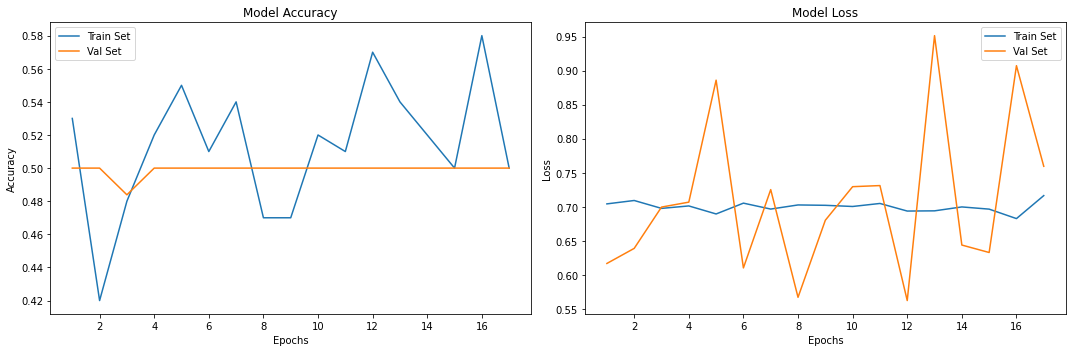

Train: 0.645
Test: 0.446
             Class 0    Class 1  accuracy   macro avg  weighted avg       aug
precision   0.454545   0.434211  0.446237    0.444378      0.444378  Original
recall      0.537634   0.354839  0.446237    0.446237      0.446237  Original
f1-score    0.492611   0.390533  0.446237    0.441572      0.441572  Original
support    93.000000  93.000000  0.446237  186.000000    186.000000  Original


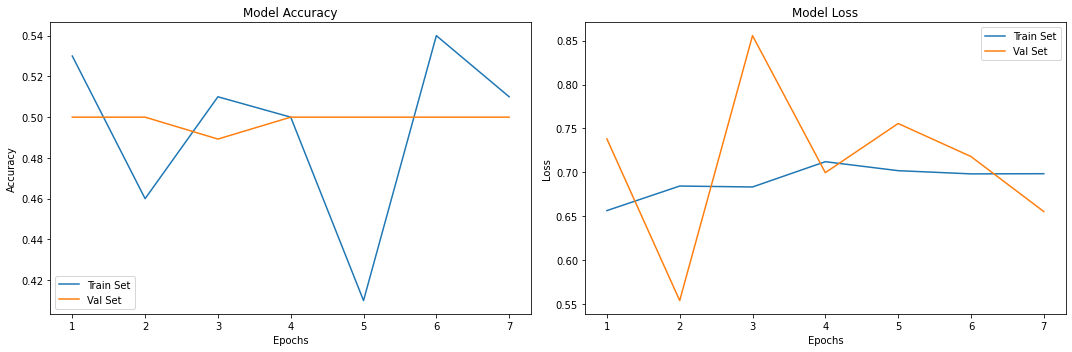

Train: 0.500
Test: 0.500


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



           Class 0    Class 1  ...  weighted avg             aug
precision      0.0   0.500000  ...      0.250000  HorizontalFlip
recall         0.0   1.000000  ...      0.500000  HorizontalFlip
f1-score       0.0   0.666667  ...      0.333333  HorizontalFlip
support       93.0  93.000000  ...    186.000000  HorizontalFlip

[4 rows x 6 columns]


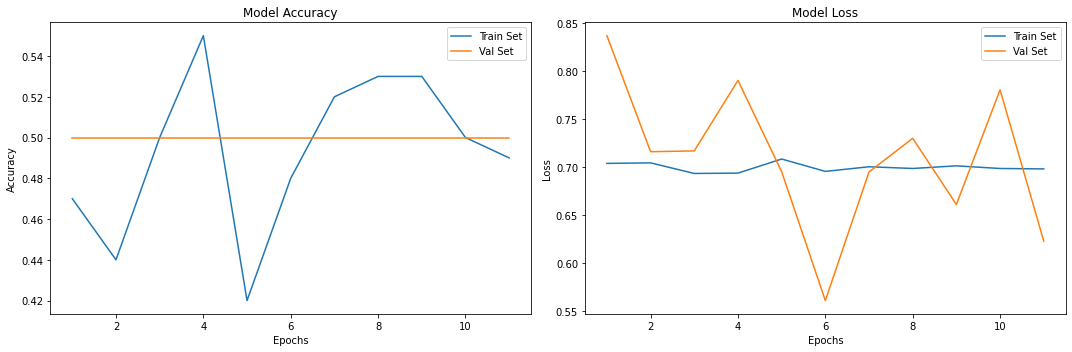

Train: 0.507
Test: 0.500


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



             Class 0  Class 1  accuracy   macro avg  weighted avg          aug
precision   0.500000      0.0       0.5    0.250000      0.250000  vertialFLip
recall      1.000000      0.0       0.5    0.500000      0.500000  vertialFLip
f1-score    0.666667      0.0       0.5    0.333333      0.333333  vertialFLip
support    93.000000     93.0       0.5  186.000000    186.000000  vertialFLip


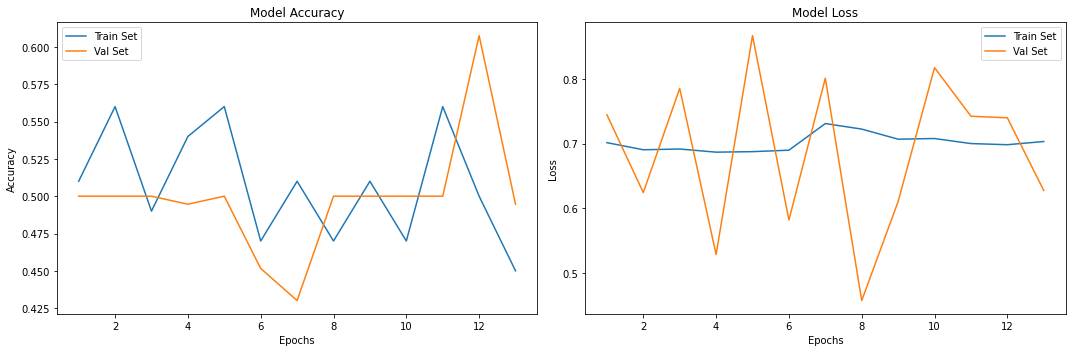

Train: 0.518
Test: 0.500


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



             Class 0  Class 1  accuracy   macro avg  weighted avg       aug
precision   0.500000      0.0       0.5    0.250000      0.250000  Rotation
recall      1.000000      0.0       0.5    0.500000      0.500000  Rotation
f1-score    0.666667      0.0       0.5    0.333333      0.333333  Rotation
support    93.000000     93.0       0.5  186.000000    186.000000  Rotation


In [ ]:
epochs=50
i=0
Results=pd.DataFrame([])
hist_results=[]
Aug=['Original','HorizontalFlip','vertialFLip','Rotation','shear','width_shift_range'
,'Horizontal+vertical','Horizonta+Rotation','Horizonta+shear','Horizonta+width_shift_range'
,'vertialFLip+Rotation','vertialFLip+Rotation','vertialFLip+shear','vertical+width_shift_range'
,'Rotation+vertical','Horizontal+Rotation','shear+Rotation','Rotation+width_shift_range'
,'shear+vertical','Horizontal+shear','shear+Rotation','shear+width_shift_range']


for i in range(len(Aug)):
  if i==0:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)

    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==1:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==2:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)    
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==3:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==5:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==6:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==7:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


  elif i==8:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==9:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True,width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1



  elif i==10:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


  elif i==11:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,shear_range=(random.randrange(0,100,10)))
      val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,shear_range=(random.randrange(0,100,10)))
      history = train_on_x_samples(1)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      
      print(df)
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      Results=Results.append(df)
      i+=1    

  elif i==12:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,vertical_flip=True,width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1




  elif i==13:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),vertical_flip=True)
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


  elif i==14:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),horizontal_flip=True)
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==15:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==16:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=(random.randrange(0,360,30)),width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


  elif i==17:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),vertical_flip=True)
      val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),vertical_flip=True)
      history = train_on_x_samples(1)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      
      print(df)
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      Results=Results.append(df)
      i+=1


  elif i==18:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),horizontal_flip=True)
      val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),horizontal_flip=True)
      history = train_on_x_samples(1)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      
      print(df)
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      Results=Results.append(df)
      i+=1



  elif i==19:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),rotation_range=(random.randrange(0,360,30)))
      val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),rotation_range=(random.randrange(0,360,30)))
      history = train_on_x_samples(1)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      
      print(df)
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      Results=Results.append(df)
      i+=1


  elif i==20:
      (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[0])
      data_processing(x_train,y_train,x_test,y_testing)
      datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),width_shift_range=(random.uniform(0.1,0.9)))
      val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,shear_range=(random.randrange(0,100,10)),width_shift_range=(random.uniform(0.1,0.9)))
      history = train_on_x_samples(1)
      train_acc_results(x_train,y_train)
      test_acc_results(x_test,y_testing)
      his_df=pd.DataFrame(history.history)
      predicted_classes = model.predict(x_test)
      predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
      target_names = ["Class {}".format(i) for i in range(num_classes)]
      report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
      df=pd.DataFrame(report_dict)
      df['aug']=Aug[i]
      
      print(df)
      df['val acc']=(history.history['val_accuracy'][-1])*100
      df['acc']=(history.history['accuracy'][-1])*100
      Results=Results.append(df)
      i+=1



    if i==21:
      break
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('Ensemble Augmentation for Generic Augmentation')
display(Results)


NST ENSEMBLE Augmnetation 
Artistic Style:STARRY NIGHT,THE WAVE,UDNIE

In [ ]:
epochs=50
i=0
Results=pd.DataFrame([])
hist_results=[]
Aug=['starry_night','starry_night_HorizontalFlip','starry_night_vertialFLip','starry_night_Rotation','starry_night_shear','starry_night_width_shift_range'
,'the_wave','the_wave_HorizontalFlip','the_wave_vertialFLip','the_wave_Rotation','the_wave_shear','the_wave_width_shift_range'
,'udnie','udnie_HorizontalFlip','udnie_vertialFLip','udnie_Rotation','udnie_shear','udnie_width_shift_range']

# classes = np.unique(y_train)
# nClasses = len(classes)
# num_classes = len(classes)

for i in range(len(Aug)):
 
# NST style 1

  if i==0:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==1:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==2:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==3:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[1])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 2

  elif i==5:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==6:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==7:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==8:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==9:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==10:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[2])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 3

  elif i==11:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==12:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==13:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==14:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==15:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==16:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[3])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


    if i==17:
      break
pd.set_option("display.max_rows", None, "display.max_columns", None)
A=Results
display(A)


NST ENSEMBLE Augmnetation 

Artistic Style:CANDY,COMPOSITION,FEATHERS

In [ ]:
epochs=50
i=0
Results=pd.DataFrame([])
hist_results=[]

Aug=['candy','candy_HorizontalFlip','candy_vertialFLip','candy_Rotation','candy_shear','candy_width_shift_range'
,'composition_vii','composition_vii_HorizontalFlip','composition_vii_vertialFLip','composition_vii_Rotation','composition_vii_shear','composition_vii_width_shift_range'
,'feathers','feathers_HorizontalFlip','feathers_vertialFLip','feathers_Rotation','feathers_shear','feathers_width_shift_range'



# classes = np.unique(y_train)
# nClasses = len(classes)
# num_classes = len(classes)

for i in range(len(Aug)):
 
# NST style 1

  if i==0:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==1:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==2:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==3:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[4])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 2

  elif i==5:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==6:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==7:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==8:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==9:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==10:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[5])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 3

  elif i==11:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==12:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==13:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==14:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==15:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==16:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[6])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


    if i==17:
      break
pd.set_option("display.max_rows", None, "display.max_columns", None)

B=Results
display(B)


NST ENSEMBLE Augmnetation 

Artistic Style:LA MUSE,MOSAIC,SCREAM

In [ ]:
epochs=50
i=0
Results=pd.DataFrame([])
hist_results=[]

Aug=['la_muse','la_muse_HorizontalFlip','la_muse_vertialFLip','la_muse_Rotation','la_muse_shear','la_muse_width_shift_range'
,'mosaic','mosaic_HorizontalFlip','mosaic_vertialFLip','mosaic_Rotation','mosaic_shear','mosaic_width_shift_range'
,'scream','scream_HorizontalFlip','scream_vertialFLip','scream_Rotation','scream_shear','scream_width_shift_range']


# classes = np.unique(y_train)
# nClasses = len(classes)
# num_classes = len(classes)

for i in range(len(Aug)):
 
# NST style 1

  if i==0:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==1:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==2:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==3:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[7])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 2

  elif i==5:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==6:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==7:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==8:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==9:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==10:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[8])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

# NST style 3

  elif i==11:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==12:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==13:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==14:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==15:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==16:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[9])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1


    if i==17:
      break
pd.set_option("display.max_rows", None, "display.max_columns", None)

C=Results
display(C)

SAMPLE PAIRING ENSEMBLE AUGMENTATION

In [ ]:
epochs=50
i=0
Results=pd.DataFrame([])
hist_results=[]

Aug=['samplepair224','samplepair224_HorizontalFlip','samplepair224_vertialFLip','samplepair224_Rotation','samplepair224_shear','samplepair224_width_shift_range']


# classes = np.unique(y_train)
# nClasses = len(classes)
# num_classes = len(classes)

for i in range(len(Aug)):
 
# NST style 1

  if i==0:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[10])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==1:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[10])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(horizontal_flip=True)
    val_datagen = ImageDataGenerator(horizontal_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==2:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[10])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(vertical_flip=True)
    val_datagen = ImageDataGenerator(vertical_flip=True)
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==3:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[11])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    val_datagen = ImageDataGenerator(rotation_range=(random.randrange(0,360,30)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[10])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    val_datagen = ImageDataGenerator(shear_range=(random.randrange(0,100,10)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

  elif i==4:
    (x_train,y_train),(x_test,y_testing)=load_data_training_and_test(Dataset[10])
    data_processing(x_train,y_train,x_test,y_testing)
    datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    val_datagen = ImageDataGenerator(width_shift_range=(random.uniform(0.1,0.9)))
    history = train_on_x_samples(1)
    train_acc_results(x_train,y_train)
    test_acc_results(x_test,y_testing)
    his_df=pd.DataFrame(history.history)
    predicted_classes = model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    report_dict=classification_report(y_testing, predicted_classes, target_names=target_names,output_dict=True)
    df=pd.DataFrame(report_dict)
    df['aug']=Aug[i]
    
    print(df)
    df['val acc']=(history.history['val_accuracy'][-1])*100
    df['acc']=(history.history['accuracy'][-1])*100
    Results=Results.append(df)
    i+=1

    if i==5:
      break
pd.set_option("display.max_rows", None, "display.max_columns", None)

D=Results
display(D)
